# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/assignment1")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
svm = LinearSVM()
for reg in regularization_strengths:
  for rate in learning_rates:
    hist = svm.train(X_train_feats, y_train, rate, reg, num_iters = 1000, verbose = True)

    predtrain = svm.predict(X_train_feats)
    predval = svm.predict(X_val_feats)

    acctrain = np.mean(predtrain == y_train)
    accval = np.mean(predval == y_val)

    results[(rate, reg)] = (acctrain, accval)
    if accval > best_val:
      best_val = accval
      best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 89.807313
iteration 100 / 1000: loss 88.229659
iteration 200 / 1000: loss 86.646987
iteration 300 / 1000: loss 85.100215
iteration 400 / 1000: loss 83.600125
iteration 500 / 1000: loss 82.120596
iteration 600 / 1000: loss 80.672883
iteration 700 / 1000: loss 79.252786
iteration 800 / 1000: loss 77.856696
iteration 900 / 1000: loss 76.497774
iteration 0 / 1000: loss 75.155986
iteration 100 / 1000: loss 63.163679
iteration 200 / 1000: loss 53.339647
iteration 300 / 1000: loss 45.293815
iteration 400 / 1000: loss 38.710640
iteration 500 / 1000: loss 33.332910
iteration 600 / 1000: loss 28.918935
iteration 700 / 1000: loss 25.292802
iteration 800 / 1000: loss 22.348081
iteration 900 / 1000: loss 19.926632
iteration 0 / 1000: loss 17.943951
iteration 100 / 1000: loss 10.197569
iteration 200 / 1000: loss 9.160832
iteration 300 / 1000: loss 9.021070
iteration 400 / 1000: loss 9.002583
iteration 500 / 1000: loss 9.000073
iteration 600 / 1000: loss 8.999749
iteration 70

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.324


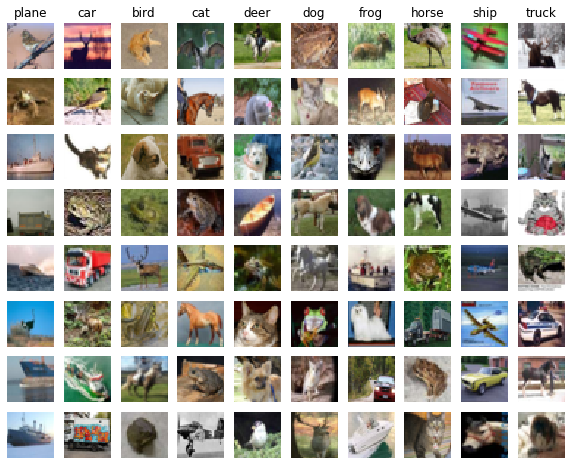

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
#hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

for i in range(25):
    lr, reg, hidden_size = random_search_hyperparams([1e-1,1,5], 
                                                     [.001, 3.01, 5], 
                                                     [150,200,250,300,350,500,1000])
    net = TwoLayerNet(input_dim, hidden_size, num_classes)
    
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    train_accuracy = (net.predict(X_train_feats) == y_train).mean()
    
    val_accuracy = (net.predict(X_val_feats) == y_val).mean()
    
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        #best_stats = stats
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/neural_net.py:104: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(scores[range(N), y]))
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/neural_net.py:100: RuntimeWarning: overflow encountered in subtract
  scores = scores - np.max(scores, axis = 1, keepdims = True)
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/neural_net.py:106: RuntimeWarning: overflow encountered in double_scalars
  loss += reg*(np.sum(W1*W1) + np.sum(W2*W2))
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/neural_net.py:100: RuntimeWarning: invalid value encountered in subtract
  scores = scores - np.max(scores, axis = 1, keepdims = True)
/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/neural_net.py:106: RuntimeWarning: overflow encountered in multiply
  loss += reg*(np.sum(W1*W1) + np.sum(W2*W2))
/content/drive/My Drive/Colab N

lr 5.000000e+00 reg 1.000000e-03 hid 250  train accuracy: 0.100265 val accuracy: 0.087000


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


lr 5.000000e+00 reg 5.000000e+00 hid 350  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e+00 reg 1.000000e-03 hid 150  train accuracy: 0.652102 val accuracy: 0.594000
lr 1.000000e-01 reg 1.000000e-03 hid 1000  train accuracy: 0.557367 val accuracy: 0.538000
lr 5.000000e+00 reg 3.010000e+00 hid 1000  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 1.000000e-03 hid 350  train accuracy: 0.551837 val accuracy: 0.537000
lr 1.000000e+00 reg 3.010000e+00 hid 150  train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e+00 reg 1.000000e-03 hid 500  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-01 reg 3.010000e+00 hid 1000  train accuracy: 0.100041 val accuracy: 0.098000
lr 1.000000e-01 reg 1.000000e-03 hid 200  train accuracy: 0.550898 val accuracy: 0.540000
lr 1.000000e-01 reg 3.010000e+00 hid 200  train accuracy: 0.100041 val accuracy: 0.098000
lr 1.000000e+00 reg 3.010000e+00 hid 300  train accuracy: 0.100265 val accuracy: 0.087000
lr 5.00

In [12]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.568
